# # Treinamento do Modelo de Detecção de Boletos

### Imports

In [73]:
import pandas as pd
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import shap
import os


In [74]:
MODEL_PATH = r'C:\Users\toyst\Documents\Projetos\Projeto da Residência - Banco do Brasil(2025.2)\backend\detectaBB_backend\modelo_boleto.pkl'

### # 2. Carregamento e Prepara os Dados

In [75]:
try:
    with open('completos.json', 'r', encoding='utf-8') as f:
        dados = json.load(f)
except FileNotFoundError:
    print("Erro: Arquivo completos.json não encontrado.")
    exit(1)

df = pd.DataFrame(dados)
print('Dados carregados:')
print(df.head())


Dados carregados:
  banco codigoBanco agencia   valor  \
0  Itaú         341    0773  890.00   
1  Itaú         341    0773  467.00   
2  Itaú         341    0773  230.00   
3  Itaú         341    0773  986.00   
4  Itaú         341    0773  766.00   

                                      linhaDigitavel  \
0  34190.00000 00000.000000 00000.000000 0 000000...   
1  34190.00000 00000.000000 00000.000000 0 000000...   
2  34190.00000 00000.000000 00000.000000 0 000000...   
3  34190.00000 00000.000000 00000.000000 0 000000...   
4  34190.00000 00000.000000 00000.000000 0 000000...   

                       classe  
0  caracteristicasVerdadeiras  
1  caracteristicasVerdadeiras  
2  caracteristicasVerdadeiras  
3  caracteristicasVerdadeiras  
4  caracteristicasVerdadeiras  


### # Mapear bancos para índices numéricos

In [76]:
mapeamento_bancos = {
    'Banco do Brasil': 0,
    'Itaú': 1,
    'Bradesco': 2,
    'Santander': 3,
    'Caixa Econômica': 4,
    'Banco Digio S.A.': 5,
    'CM CAPITAL MARKETS CORRETORA DE CÂMBIO, TÍTULOS E VALORES MOBILIÁRIOS LTDA': 6,
    'Banco Clássico S.A.': 7,
    'Credialiança Cooperativa de Crédito Rural': 8,
    'CREDICOAMO CREDITO RURAL COOPERATIVA': 9,
    # Bancos falsos
    'OLIVEIRA TRUST DISTRIBUIDORA DE TÍTULOS E VALORES MOBILIARIOS S.A.': 10,
    'Pagseguro Internet S.A. – PagBank': 11,
    'NU Pagamentos S.A. – Nubank': 12,
    'ATIVA INVESTIMENTOS S.A. CORRETORA DE TÍTULOS, CÂMBIO E VALORES': 13,
    'Banco Inbursa S.A.': 14,
    'SOROCRED CRÉDITO, FINANCIAMENTO E INVESTIMENTO S.A.': 15,
    'Banco Finaxis S.A.': 16,
    'SOCRED S.A. – SOCIEDADE DE CRÉDITO AO MICROEMPREENDEDOR E À EMPRESA DE PEQUENO P': 17
}
df['banco'] = df['banco'].map(mapeamento_bancos).fillna(0).astype(float)


# Mapear classe
df['classe'] = df['classe'].map({
    'caracteristicasVerdadeiras': 1,
    'caracteristicasFalsas': 0
}).astype(float)

In [77]:
print(df.columns.tolist())


['banco', 'codigoBanco', 'agencia', 'valor', 'linhaDigitavel', 'classe']


### # Processar linha digitável e selecionar as features

In [78]:
df['linhaDigitavel'] = df['linhaDigitavel'].str.replace(' ', '').str.replace('.', '').astype(str)
df['linha_codBanco'] = df['linhaDigitavel'].str.slice(0, 3).fillna('0').astype(float)
df['linha_moeda'] = df['linhaDigitavel'].str.slice(3, 4).fillna('9').astype(float)
df['linha_valor'] = df['linhaDigitavel'].str.slice(-10).fillna('0').astype(float)

# Selecionar features
features = ['banco', 'codigoBanco', 'agencia', 'valor', 
            'linha_codBanco', 'linha_moeda', 'linha_valor']

X = df[features].fillna(0).astype(float)
y = df['classe'].fillna(0).astype(float)

print('✅ Features preparadas:')
print(X.head())

✅ Features preparadas:
   banco  codigoBanco  agencia  valor  linha_codBanco  linha_moeda  \
0    1.0        341.0    773.0  890.0           341.0          9.0   
1    1.0        341.0    773.0  467.0           341.0          9.0   
2    1.0        341.0    773.0  230.0           341.0          9.0   
3    1.0        341.0    773.0  986.0           341.0          9.0   
4    1.0        341.0    773.0  766.0           341.0          9.0   

   linha_valor  
0      89000.0  
1      46700.0  
2      23000.0  
3      98600.0  
4      76600.0  


### Divisão dos dados

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Treino: {X_train.shape}, Teste: {X_test.shape}')

Treino: (400, 7), Teste: (100, 7)


### Treinar o modelo

In [80]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


# Avaliar
y_pred = model.predict(X_test)
print('Acurácia:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Falso', 'Verdadeiro']))


Acurácia: 0.8
Classification Report:
              precision    recall  f1-score   support

       Falso       0.89      0.72      0.80        54
  Verdadeiro       0.73      0.89      0.80        46

    accuracy                           0.80       100
   macro avg       0.81      0.81      0.80       100
weighted avg       0.82      0.80      0.80       100



## Análise com SHAP - XAI

In [81]:
# 5. Análise com SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_exp_test = explainer(X_test)

## # Plotar resumo para a classe 'Falso' (índice 0)

✅ Dimensões:
X_shap: (100, 7)
shap_values[0]: (7, 2)
shap_values[1]: (7, 2)


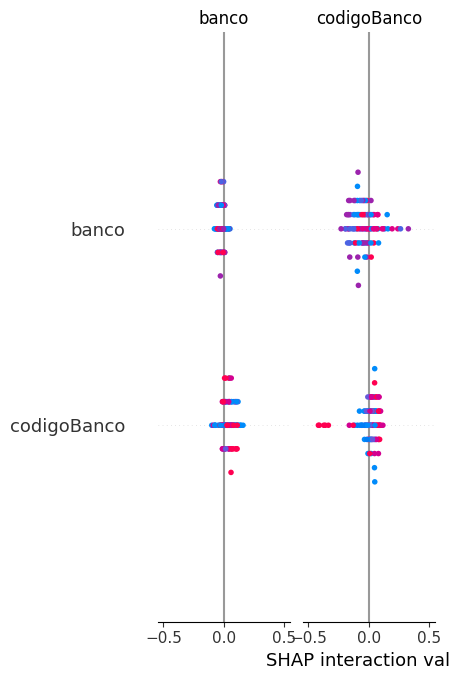

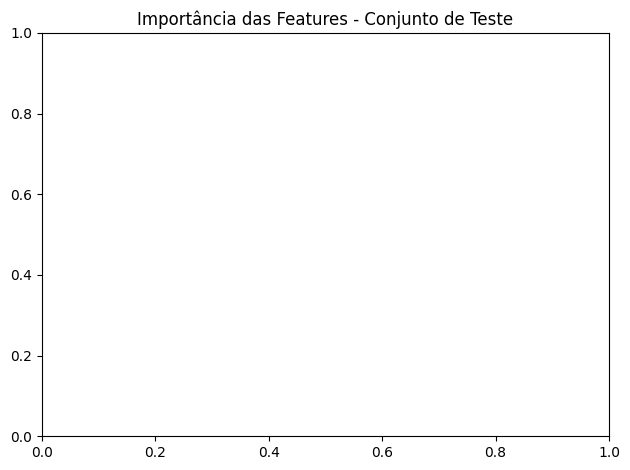

In [82]:
# Transformar X_test em numpy (necessário para o SHAP)
X_shap = X_test.to_numpy()

print("✅ Dimensões:")
print("X_shap:", X_shap.shape)
print("shap_values[0]:", shap_values[0].shape)
print("shap_values[1]:", shap_values[1].shape)

# # Plot para classe Falso
# shap.summary_plot(shap_values[0], X_shap, feature_names=features, plot_type='bar')
# plt.title('Importância das Features - Classe Falso')
# plt.tight_layout()
# plt.show()

# # Plot para classe Verdadeiro
# shap.summary_plot(shap_values[1], X_shap, feature_names=features, plot_type='bar')
# plt.title('Importância das Features - Classe Verdadeiro')
# plt.tight_layout()
# plt.show()
shap.summary_plot(shap_exp_test.values, X_test, feature_names=features, plot_type='bar')
plt.title('Importância das Features - Conjunto de Teste')
plt.tight_layout()
plt.show()

In [83]:
print("X_test shape:", X_test.shape)
print("X_shap shape:", X_shap.shape)

for i, sv in enumerate(shap_values):
    print(f"shap_values[{i}] shape:", sv.shape)


X_test shape: (100, 7)
X_shap shape: (100, 7)
shap_values[0] shape: (7, 2)
shap_values[1] shape: (7, 2)
shap_values[2] shape: (7, 2)
shap_values[3] shape: (7, 2)
shap_values[4] shape: (7, 2)
shap_values[5] shape: (7, 2)
shap_values[6] shape: (7, 2)
shap_values[7] shape: (7, 2)
shap_values[8] shape: (7, 2)
shap_values[9] shape: (7, 2)
shap_values[10] shape: (7, 2)
shap_values[11] shape: (7, 2)
shap_values[12] shape: (7, 2)
shap_values[13] shape: (7, 2)
shap_values[14] shape: (7, 2)
shap_values[15] shape: (7, 2)
shap_values[16] shape: (7, 2)
shap_values[17] shape: (7, 2)
shap_values[18] shape: (7, 2)
shap_values[19] shape: (7, 2)
shap_values[20] shape: (7, 2)
shap_values[21] shape: (7, 2)
shap_values[22] shape: (7, 2)
shap_values[23] shape: (7, 2)
shap_values[24] shape: (7, 2)
shap_values[25] shape: (7, 2)
shap_values[26] shape: (7, 2)
shap_values[27] shape: (7, 2)
shap_values[28] shape: (7, 2)
shap_values[29] shape: (7, 2)
shap_values[30] shape: (7, 2)
shap_values[31] shape: (7, 2)
shap

In [84]:
# DataFrame da primeira amostra
dado_teste = df[features].iloc[[0]].astype(float)  # DataFrame 1x7

# Predição
pred = int(model.predict(dado_teste)[0])

# SHAP Explanation moderno
shap_exp = explainer(dado_teste)

# Valores SHAP para a classe predita
shap_vals_classe = shap_exp.values[0][pred]  # primeira amostra, classe predita

# Array das features (somente as usadas pelo modelo)
features_array = dado_teste.iloc[0].to_numpy()



### # Plotar resumo para a classe 'Verdadeiro' (índice 1)


In [85]:
# shap.summary_plot(shap_values[1], X_test, plot_type='bar', feature_names=features, show=False)
# plt.title('Importância das Features para Classe Verdadeiro')
# plt.tight_layout()
# plt.show()

### Salvar o modelo

In [86]:
pickle.dump(model, open(MODEL_PATH, 'wb'))
print(f'✅ Modelo salvo em: {MODEL_PATH}')



✅ Modelo salvo em: C:\Users\toyst\Documents\Projetos\Projeto da Residência - Banco do Brasil(2025.2)\backend\detectaBB_backend\modelo_boleto.pkl


In [ ]:


# Função para explicar predições
def explicar_predicao(explainer, dado, features):
    try:
        shap_exp = explainer(dado)
        pred = int(model.predict(dado)[0])
        
        # Ajustar shap_values para classificador binário ou multi-classe
        shap_values = shap_exp.values[0] if len(shap_exp.values.shape) > 2 else shap_exp.values
        if len(shap_values.shape) > 1:
            shap_values = shap_values[pred]
        
        print("Valores SHAP brutos:", shap_values)  # Para depuração
        
        explicacoes = []
        for i, val in enumerate(shap_values):
            if abs(val) > 0.001:  # Reduzir limiar
                direcao = "aumentou" if val > 0 else "reduziu"
                explicacoes.append(f"- Feature '{features[i]}' {direcao} a probabilidade de ser verdadeiro (impacto {val:.3f}).")
        return "\n".join(explicacoes) if explicacoes else "Nenhuma feature teve impacto relevante (limiar 0.001)."
    except Exception as e:
        return f"Erro ao explicar predição: {str(e)}"

### Testes com exemplos

In [ ]:


# Testes
testes = [
    {  # Falso: OLIVEIRA TRUST
        'banco': 10, 'codigoBanco': 700, 'agencia': 712, 'valor': 834629.43,
        'linha_codBanco': 111, 'linha_moeda': 0, 'linha_valor': 83462943
    },
    {  # Falso: Nubank
        'banco': 12, 'codigoBanco': 188, 'agencia': 101, 'valor': 731538.0,
        'linha_codBanco': 260, 'linha_moeda': 3, 'linha_valor': 94228611
    }
]

features = ['banco', 'codigoBanco', 'agencia', 'valor', 'linha_codBanco', 'linha_moeda', 'linha_valor']

for i, teste in enumerate(testes):
    try:
        dado_teste = pd.DataFrame([teste])[features].astype(float)
        pred = int(model.predict(dado_teste)[0])
        prob = model.predict_proba(dado_teste)[0].tolist()
        print(f'\nBoleto {i+1}: Predição = {"Verdadeiro" if pred == 1 else "Falso"}, Probabilidades = {prob}')
        
        # Explicação SHAP
        shap_exp = explainer(dado_teste)
        explicacoes = explicar_predicao(explainer, dado_teste, features)
        print(explicacoes)
        
        # Force plot
        shap.plots.force(
            explainer.expected_value[pred] if len(explainer.expected_value) > 1 else explainer.expected_value,
            shap_exp.values[0] if len(shap_exp.values.shape) > 2 else shap_exp.values,
            dado_teste.iloc[0].to_numpy(),
            feature_names=features,
            matplotlib=True
        )
        plt.show()
    except Exception as e:
        print(f"Erro no boleto {i+1}: {str(e)}")


Boleto 1: Predição = Falso, Probabilidades = [0.97, 0.03]
Valores SHAP brutos: [ 0.00361008 -0.00361008]
- Feature 'banco' aumentou a probabilidade de ser verdadeiro (impacto 0.004).
- Feature 'codigoBanco' reduziu a probabilidade de ser verdadeiro (impacto -0.004).
Erro no boleto 1: matplotlib = True is not yet supported for force plots with multiple samples!

Boleto 2: Predição = Falso, Probabilidades = [0.98, 0.02]
Valores SHAP brutos: [ 0.00287933 -0.00287933]
- Feature 'banco' aumentou a probabilidade de ser verdadeiro (impacto 0.003).
- Feature 'codigoBanco' reduziu a probabilidade de ser verdadeiro (impacto -0.003).
Erro no boleto 2: matplotlib = True is not yet supported for force plots with multiple samples!
